In [1]:
# imports
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from VAN import *


Différentes distributions de probabilité pour des spins de taille 6

In [2]:
taille=100
## différentes distributions de probabilité

def p(s): # seuls deux spins ont une proba non nulle
    if torch.eq(s, torch.tensor([1.0 for i in range(50)] + [0.0 for i in range(50)])).all().item():
        return 0.499
    elif torch.eq(s, torch.tensor([0.0 for i in range(50)] + [1.0 for i in range(50)])).all().item():
        return 0.499
    else:
        
        return 1e-8
    
def uniforme(s): 
    return 1/(2**taille)

def p3(s): # deux spins ont une proba non nulle et l'un prévaut sur l'autre
    if torch.eq(s, torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])).all().item():
        return 0.75
    elif torch.eq(s, torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])).all().item():
        return 0.25
    else:
        return 0.001


**Test des différents modèles**

Modèle 1 : tous les spins ont une proba non nulle sauf deux:

In [3]:
mymodel=VAN(taille, torch.sigmoid)

l=train(mymodel, p, n_iter=600, lr=1e-1, train_size=100)

plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 1')

0
Epoch 0: -1.1920928955078125e-07
1
2
3
4
5
6


KeyboardInterrupt: 

In [29]:
y1=(torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0]))
y2=(torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
y3=(torch.tensor([0., 0., 0., 0., 0., 1.]))
y4=(torch.tensor([0., 0., 0., 1., 1., 1.]))

Test du modèle 1

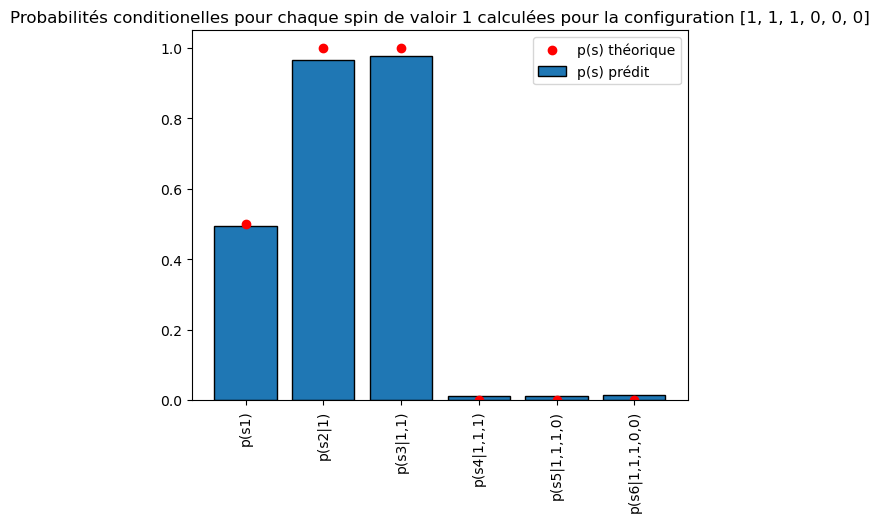

In [30]:
plt.bar(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , mymodel(y1).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [1, 1, 1, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , [0.5, 1, 1, 0, 0, 0], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()

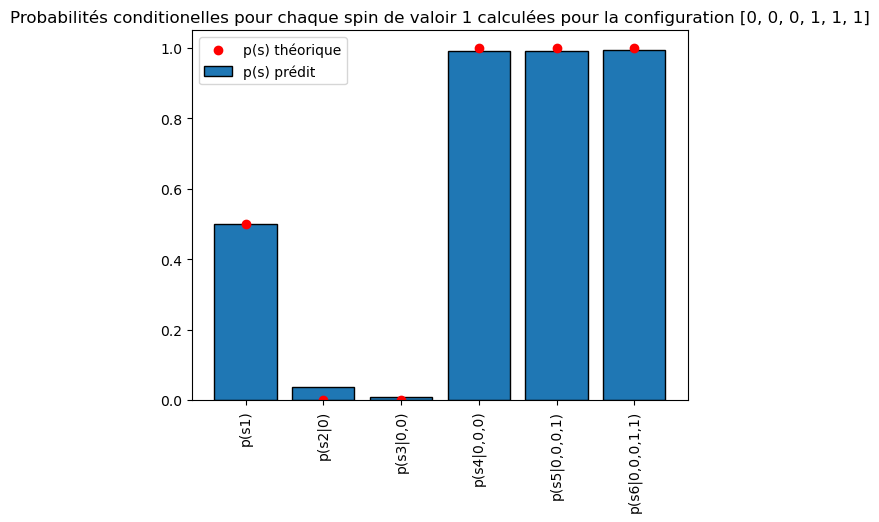

In [20]:
#idem pour y4
plt.bar(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,1)', 'p(s6|0,0,0,1,1)']) , mymodel(y4).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [0, 0, 0, 1, 1, 1]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,1)', 'p(s6|0,0,0,1,1)']) , [0.5, 0, 0, 1, 1, 1], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()


Calcul des probas totales:


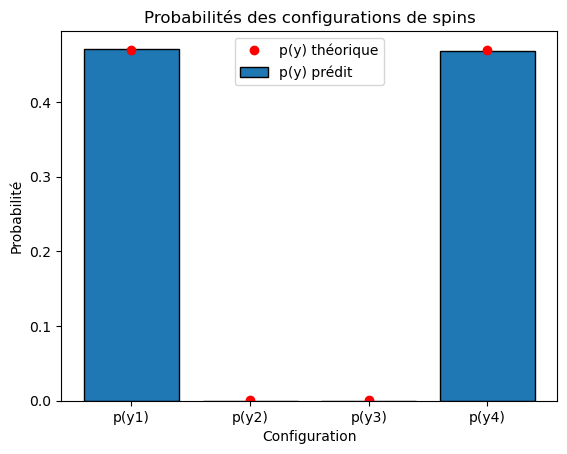

In [27]:
py1=calculer_proba(y1, mymodel)
py2=calculer_proba(y2, mymodel)
py3=calculer_proba(y3, mymodel)
py4=calculer_proba(y4, mymodel)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [p(y1), p(y2), p(y3), p(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()


Second modèle: loi uniforme

Epoch 0: 0.0
Epoch 20: 9.989096724893898e-06
Epoch 40: 1.1619194992817938e-06
Epoch 60: 2.0643437892431393e-07
Epoch 80: -2.5004737835843116e-08
Epoch 100: -1.9791286831605248e-08
Epoch 120: -3.320550945318246e-09
Epoch 140: -9.930442246286475e-08
Epoch 160: 3.599554787570014e-08
Epoch 180: 2.3376856006507296e-09


Text(0.5, 1.0, 'Entraînement modèle uniforme')

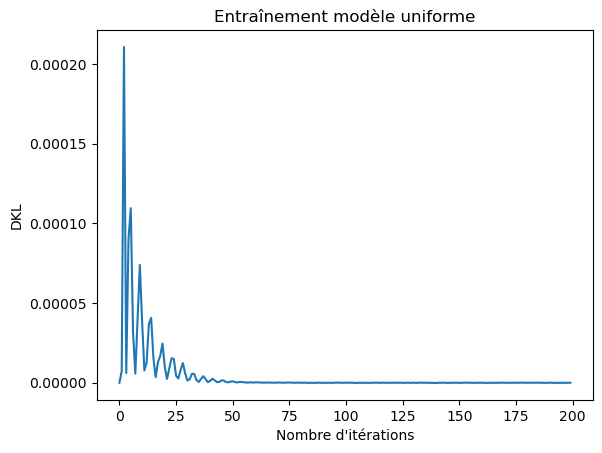

In [6]:
model_uniforme=VAN(6, torch.sigmoid)
l=train(model_uniforme, uniforme, n_iter=200, lr=1e-2, train_size=100)


plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle uniforme')

Cela marche très bien pour l'uniforme car on initialise le VAN pour qu'il ressorte une loi uniforme

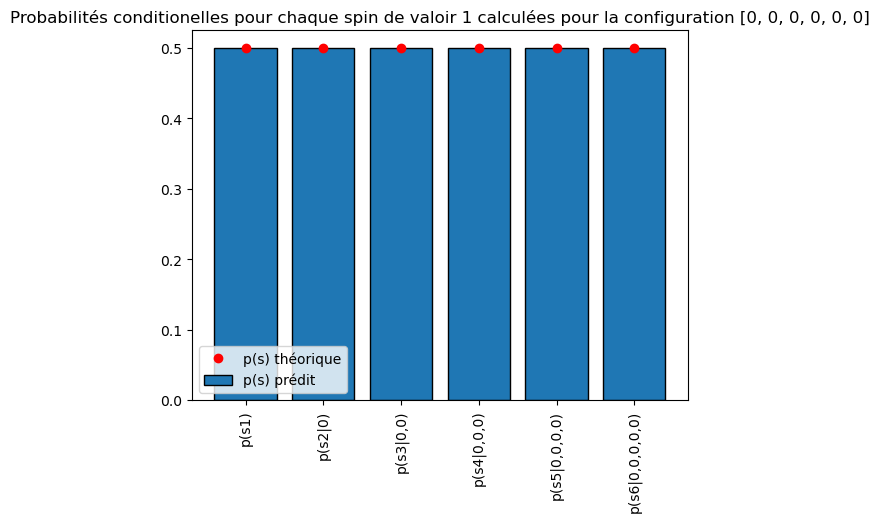

In [11]:
plt.bar(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,0)', 'p(s6|0,0,0,0,0)']) , model_uniforme(y2).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [0, 0, 0, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,0)', 'p(s6|0,0,0,0,0)']) , [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()


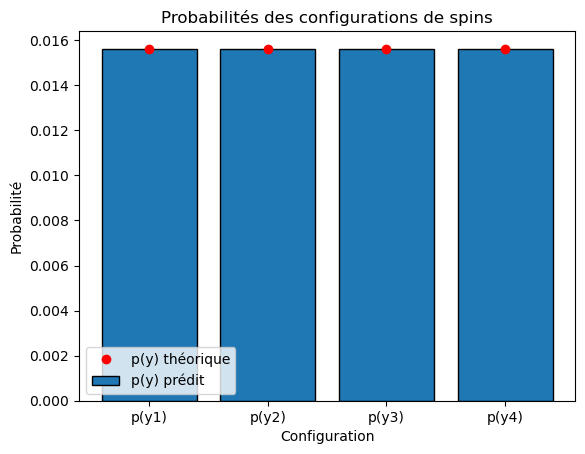

In [30]:
py1=calculer_proba(y1, model_uniforme)
py2=calculer_proba(y2, model_uniforme)
py3=calculer_proba(y3, model_uniforme)
py4=calculer_proba(y4, model_uniforme)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [uniforme(y1), uniforme(y2), uniforme(y3), uniforme(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()

Troisième modèle : 

Epoch 0: 2.744621515274048
Epoch 20: 0.5525966882705688
Epoch 40: 0.3284997045993805
Epoch 60: 0.2741461396217346
Epoch 80: 0.21348321437835693
Epoch 100: 0.1686772257089615
Epoch 120: 0.07030923664569855
Epoch 140: 0.04175059497356415
Epoch 160: 0.01168818213045597
Epoch 180: 0.02155134454369545


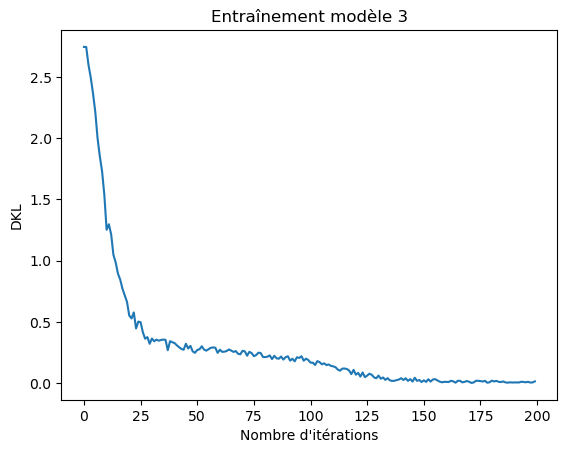

In [12]:
model3=VAN(6, torch.sigmoid)
l=train(model3, p3, n_iter=200, lr=1e-1, train_size=100)
plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 3')
plt.show()

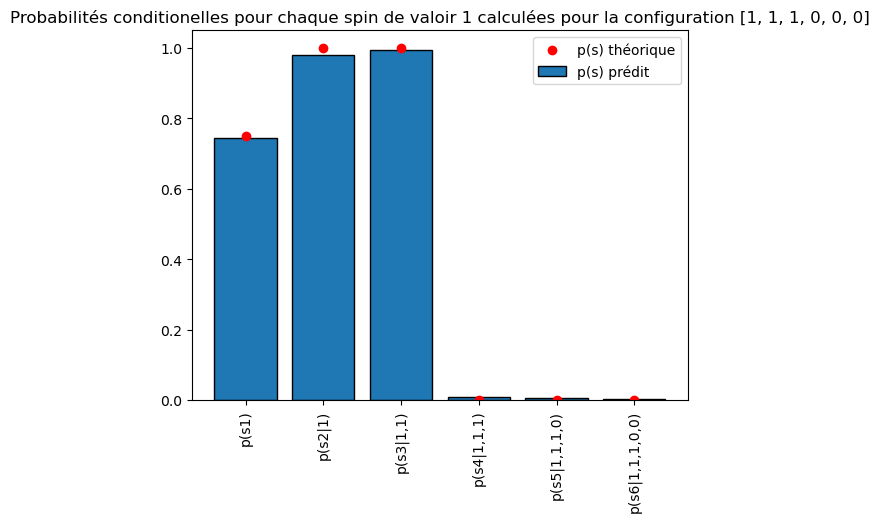

In [13]:
plt.bar(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , model3(y1).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [1, 1, 1, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , [0.75, 1, 1, 0, 0, 0], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()

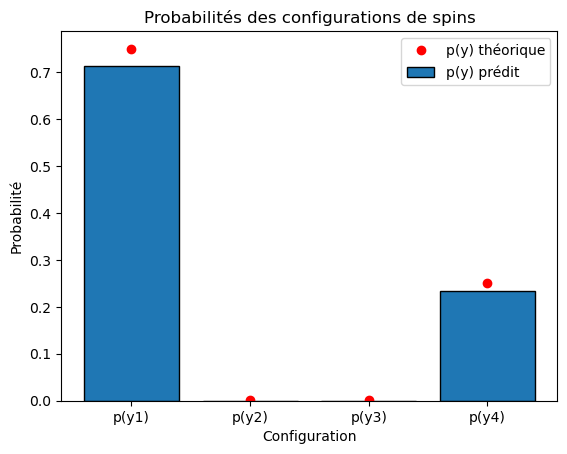

In [31]:
# probabilités totales:
py1=calculer_proba(y1, model3)
py2=calculer_proba(y2, model3)
py3=calculer_proba(y3, model3)
py4=calculer_proba(y4, model3)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [p3(y1), p3(y2), p3(y3), p3(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()

Epoch 0: -9.915548844219302e-07
Epoch 20: -1.0541720390319824
Epoch 40: 0.2783868908882141
Epoch 60: -0.354751318693161
Epoch 80: 0.18312019109725952
Epoch 100: -0.21513904631137848
Epoch 120: -0.03237030655145645
Epoch 140: 0.07378288358449936
Epoch 160: -0.0669080838561058
Epoch 180: 0.27950236201286316


Text(0.5, 1.0, 'Entraînement modèle 1')

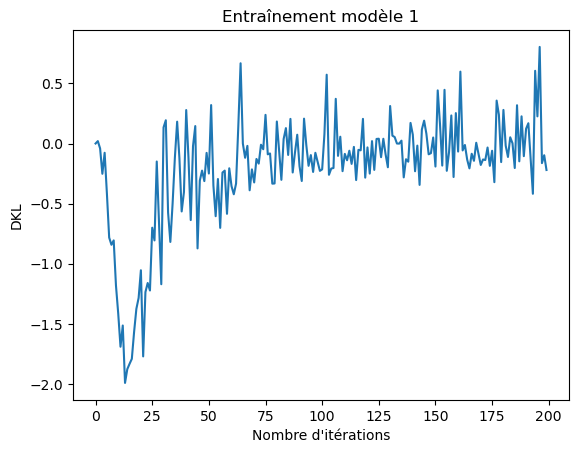

In [16]:
#test prof 


def log_p(spins):
    return torch.tensor([torch.log(torch.tensor(p3(spin)) ) for spin in spins])
from VAN_new import *
import matplotlib.pyplot as plt
taille=6
mymodel=VAN(taille, torch.sigmoid)

l=train(mymodel,log_p,  n_iter=200, lr=1e-1)

plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 1')